In [1]:
import os
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime

from fbprophet import Prophet

In [2]:
df_sales = pd.read_csv('../data/sales_train_v2.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'],  dayfirst=True)

In [3]:
df_sales_fbprophet = df_sales.loc[(df_sales['item_cnt_day']>0)&
                                  #(df_sales['date']>pd.to_datetime('2014-10-01'))&
                                ((df_sales['item_id']==20949))]

df_sales_fbprophet = df_sales_fbprophet.drop(['date','shop_id','item_id','item_price'],axis=1)
df_sales_fbprophet

,date_block_num,item_cnt_day
352379,3,12.0
352399,3,13.0
352400,3,4.0
352401,3,4.0
352455,3,2.0
...,...,...
2930644,33,1.0
2930645,33,2.0
2930646,33,3.0
2930647,33,2.0


In [4]:
# date_block_num - a consecutive month number. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
df_sales_fbprophet['date_month'] = datetime.datetime(2013, 1, 31).date() + df_sales_fbprophet['date_block_num'].apply(pd.offsets.MonthEnd) 
df_sales_fbprophet = df_sales_fbprophet.groupby(['date_month','date_block_num'])['item_cnt_day'].sum().reset_index(name='item_cnt_month')
df_sales_fbprophet

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,date_month,date_block_num,item_cnt_month
0,2013-04-30,3,255.0
1,2013-05-31,4,3727.0
2,2013-06-30,5,8424.0
3,2013-07-31,6,7269.0
4,2013-08-31,7,7296.0
5,2013-09-30,8,7945.0
6,2013-10-31,9,7738.0
7,2013-11-30,10,8537.0
8,2013-12-31,11,12557.0
9,2014-01-31,12,7329.0


In [5]:
df_sales_fbprophet = df_sales_fbprophet.rename(columns={"date_month": "ds", "item_cnt_month": "y"})
df_sales_fbprophet

,ds,date_block_num,y
0,2013-04-30,3,255.0
1,2013-05-31,4,3727.0
2,2013-06-30,5,8424.0
3,2013-07-31,6,7269.0
4,2013-08-31,7,7296.0
5,2013-09-30,8,7945.0
6,2013-10-31,9,7738.0
7,2013-11-30,10,8537.0
8,2013-12-31,11,12557.0
9,2014-01-31,12,7329.0


In [6]:
# put in limits
df_sales_fbprophet['floor']=0
df_sales_fbprophet['cap']=df_sales_fbprophet['y'].max()

In [7]:
m = Prophet(daily_seasonality=False, yearly_seasonality=True,
            growth='logistic',seasonality_mode='multiplicative')
m.fit(df_sales_fbprophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


In [8]:
# find how many periods we need by finding the last month
days_to_predict = pd.to_datetime('2016-1-31') - df_sales_fbprophet['ds'].max()
months_to_predict = round(days_to_predict.days/31)

In [9]:
# predict 2 months into the future
future = m.make_future_dataframe(periods=months_to_predict, freq='M')
future['floor']=0
future['cap']=df_sales_fbprophet['y'].max()

future.tail()

,ds,floor,cap
29,2015-09-30,0,12557.0
30,2015-10-31,0,12557.0
31,2015-11-30,0,12557.0
32,2015-12-31,0,12557.0
33,2016-01-31,0,12557.0


In [10]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
29,2015-09-30,3401.551628,2592.647330,4196.743256
30,2015-10-31,3805.984718,3018.296282,4576.720112
31,2015-11-30,4101.278160,3264.044108,4872.423548
32,2015-12-31,8262.808516,7482.982898,9073.237765
33,2016-01-31,6013.187493,5153.750791,6806.176238


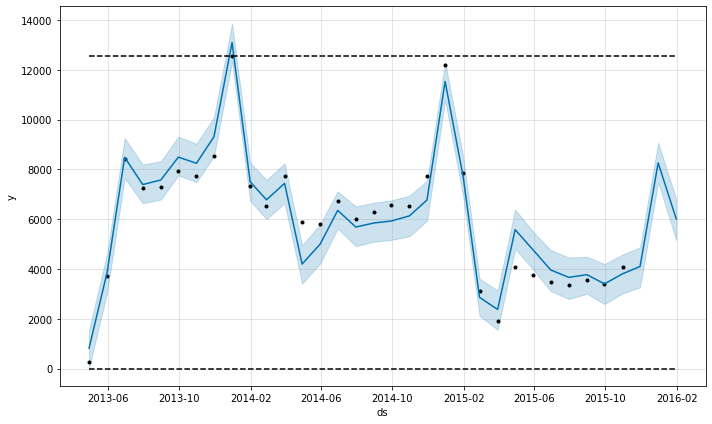

In [11]:
fig1 = m.plot(forecast)

In [12]:
# forecast
forecast[['ds','yhat']]

,ds,yhat
0,2013-04-30,817.748629
1,2013-05-31,3873.366057
2,2013-06-30,8486.193090
3,2013-07-31,7391.512610
4,2013-08-31,7576.618525
5,2013-09-30,8494.758851
6,2013-10-31,8245.913607
7,2013-11-30,9313.869134
8,2013-12-31,13098.842933
9,2014-01-31,7505.023636


In [13]:
# forecast for Nov 2015
forecast.loc[(forecast['ds']==pd.to_datetime('2015-11-30'))]['yhat']

31    4101.27816
Name: yhat, dtype: float64